In [1]:
import pandas as pd
import os

In [2]:
f_list = range(1, 21)

In [3]:
res_dict = {}
for i in f_list:
    res_dict[i] = pd.read_csv('res5_{}.csv'.format(i), index_col=0)

In [4]:
ensg2gene = pd.read_csv('../../../hg38_ensembl2gene.txt', sep='\t', index_col=0)
ensg2gene['gene_id'] = ensg2gene['gene_id'].str.lstrip(' ')
ensg2gene.head()

,biotype,gene_id,chr,start,stop
ensembl,,,,,
ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,chr1,11869,14409
ENSG00000227232.5,unprocessed_pseudogene,WASH7P,chr1,14404,29570
ENSG00000278267.1,miRNA,MIR6859-1,chr1,17369,17436
ENSG00000243485.5,lncRNA,MIR1302-2HG,chr1,29554,31109
ENSG00000284332.1,miRNA,MIR1302-2,chr1,30366,30503


In [5]:
for i in range(1, 21):
    res_dict[i]['symbol'] = res_dict[i].index.map(ensg2gene['gene_id'])
    res_dict[i]['biotype'] = res_dict[i].index.map(ensg2gene['biotype'])

In [6]:
res_dict[1].shape

(30244, 8)

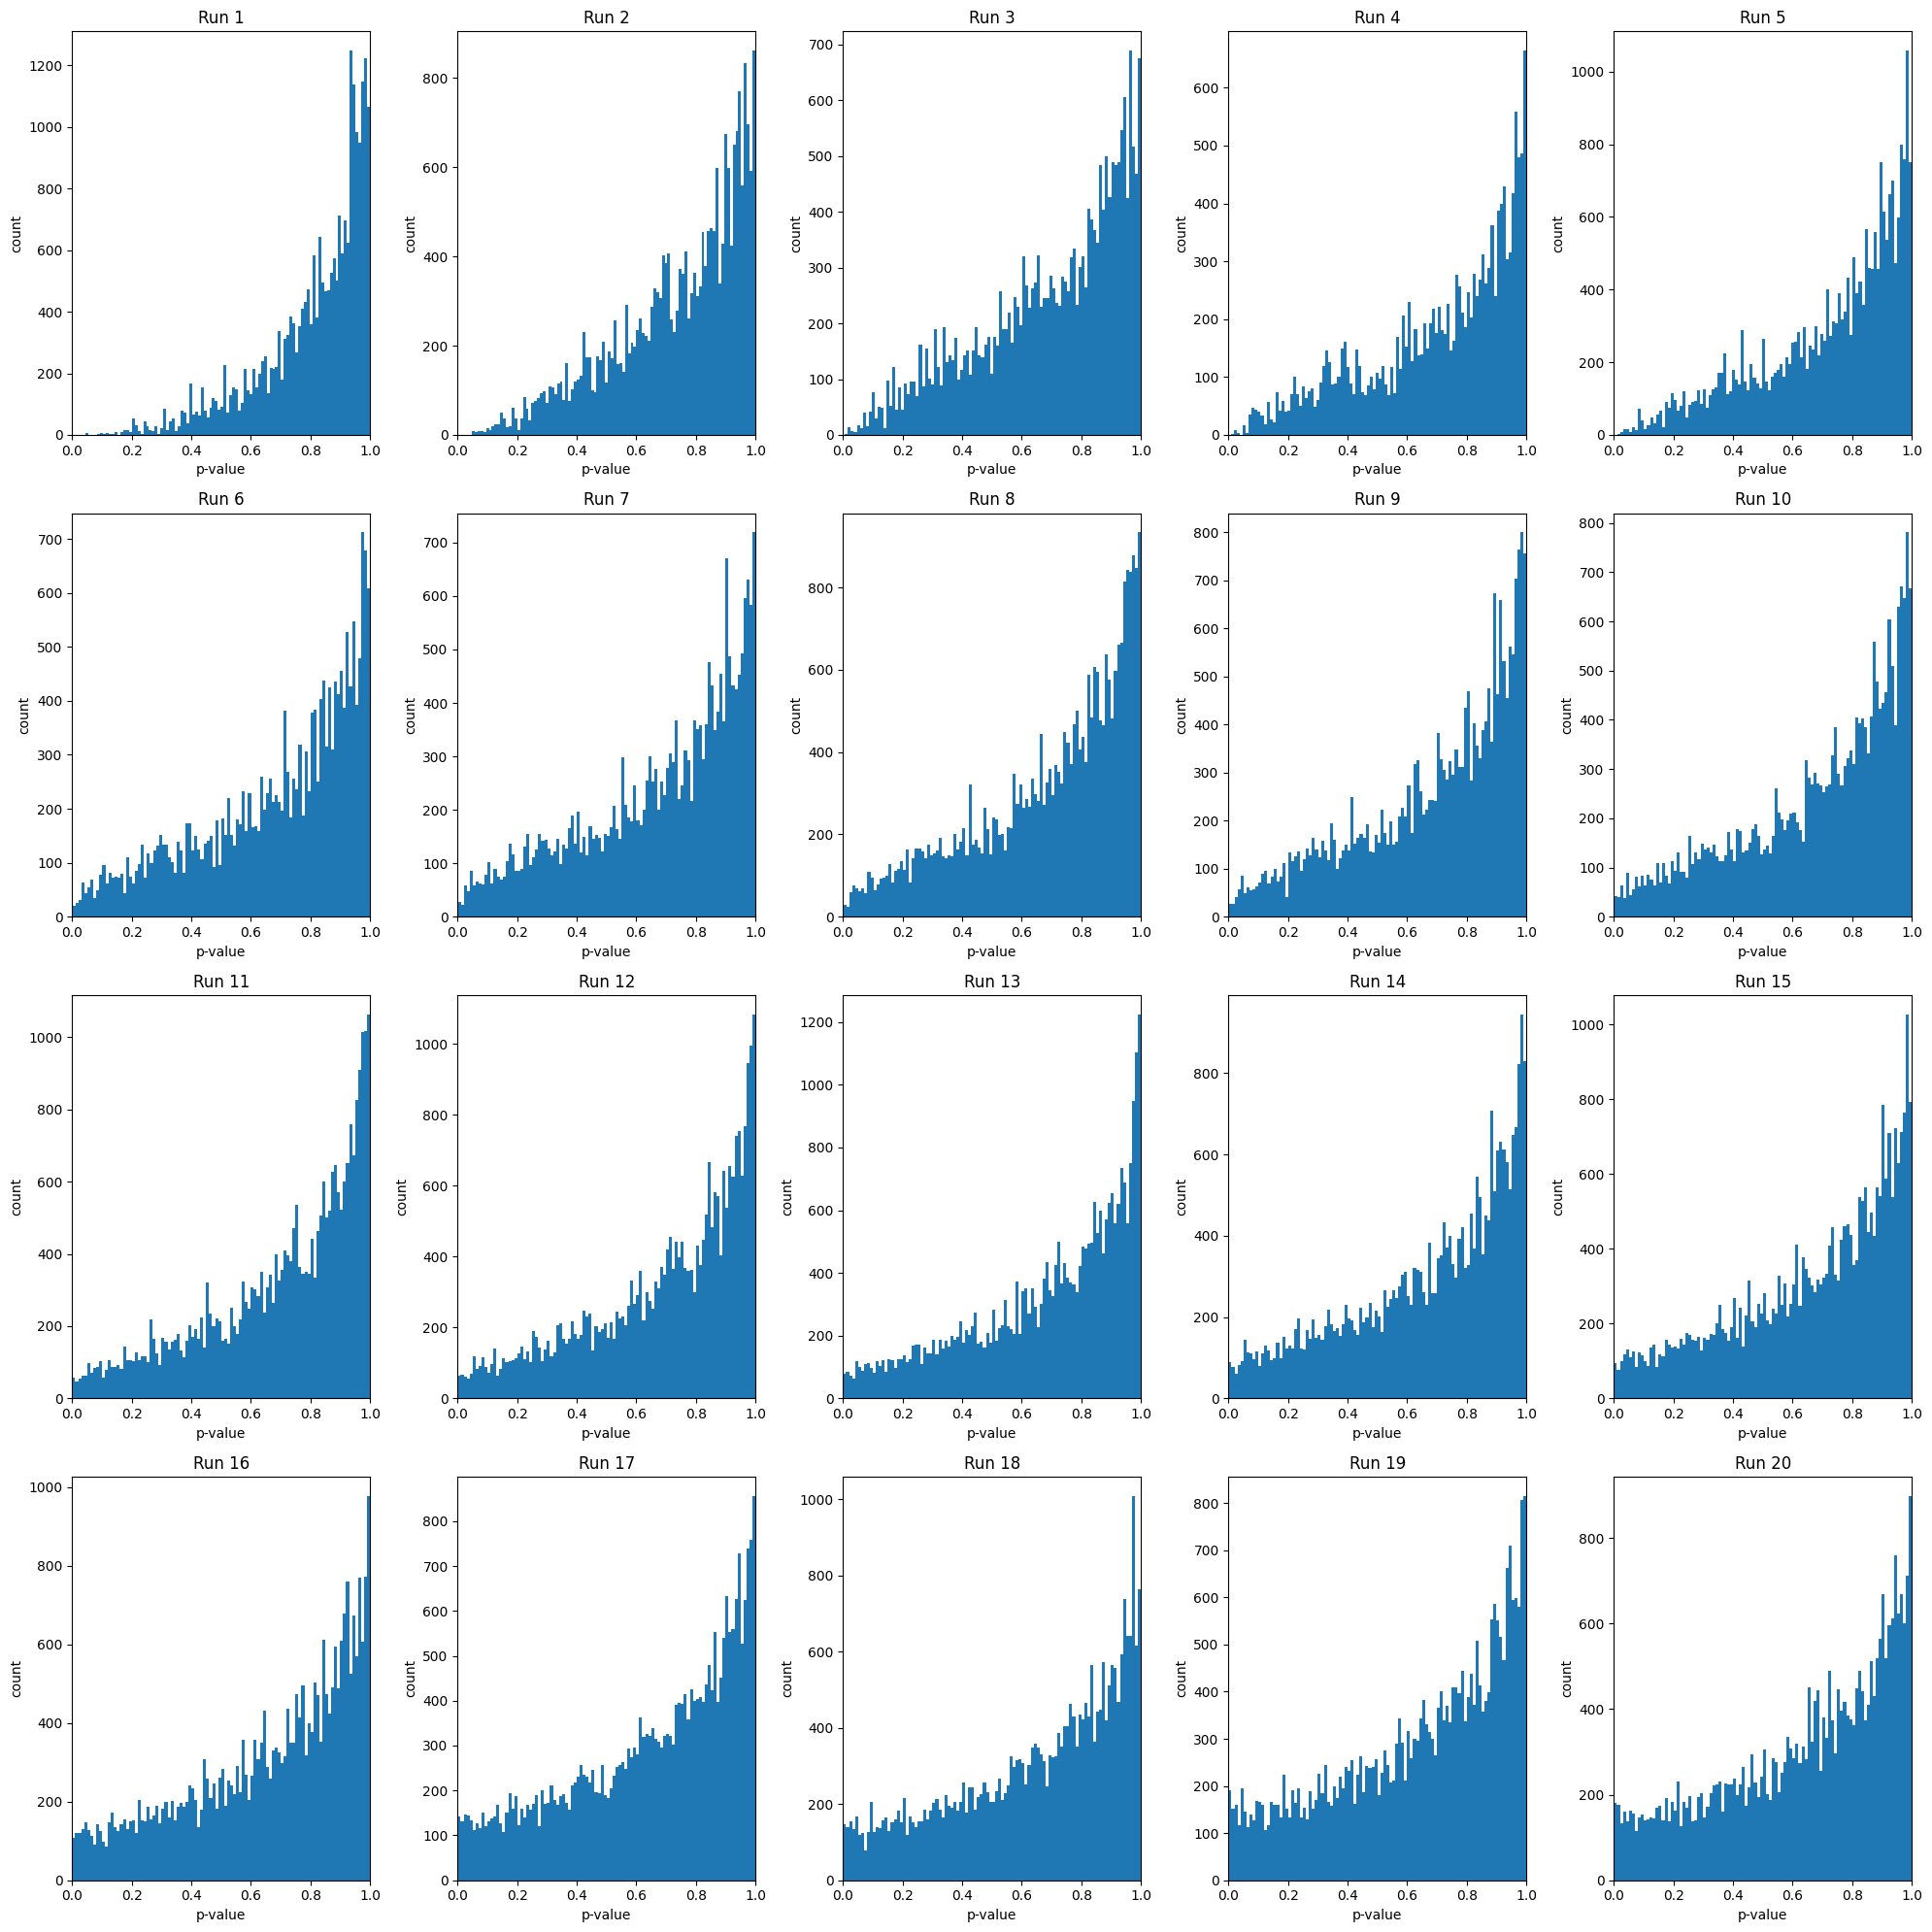

In [7]:
#plot all pval histograms on one plot in a 5x4 grid
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(4, 5, figsize=(20, 20))
axes = axes.flatten()
for i in range(1, 21):
    axes[i-1].hist(res_dict[i]['padj'], bins=100)
    axes[i-1].set_title('Run {}'.format(i))
    axes[i-1].set_xlabel('p-value')
    axes[i-1].set_ylabel('count')
    axes[i-1].set_xlim(0, 1)
    
plt.tight_layout()
plt.savefig('pval_hist.png', bbox_inches='tight', dpi=300)

In [8]:
#fit a best fit line (y = mx + b) to each histogram
import numpy as np
from scipy.optimize import curve_fit
best_fit = pd.DataFrame(columns=['run', 'slope', 'intercept'])
for i in range(1, 21):
    #drop NA values
    res_dict[i] = res_dict[i].dropna()
    hist, bins = np.histogram(res_dict[i]['padj'], bins=100)
    bins = bins[:-1]
    def func(x, m, b):
        return m*x + b
    slope_intercept, pcov = curve_fit(func, bins, hist)
    slope = slope_intercept[0]
    intercept = slope_intercept[1]
    best_fit.loc[i, 'run'] = i
    best_fit.loc[i, 'slope'] = slope
    best_fit.loc[i, 'intercept'] = intercept
#get the slope of each line
slope_df = pd.DataFrame()
for i in range(1, 21):
    slope_df.loc[i, 'slope'] = best_fit.loc[i, 'slope']
slope_df['run'] = slope_df.index
slope_df.head()

,slope,run
1,915.270810,1
2,676.476529,2
3,503.473791,3
4,385.665216,4
5,653.871724,5


In [9]:
slope_df.describe()

,slope,run
count,20.000000,20.00000
mean,573.269590,10.50000
std,119.651210,5.91608
min,385.665216,1.00000
25%,502.468485,5.75000
50%,544.643754,10.50000
75%,659.741235,15.25000
max,915.270810,20.00000


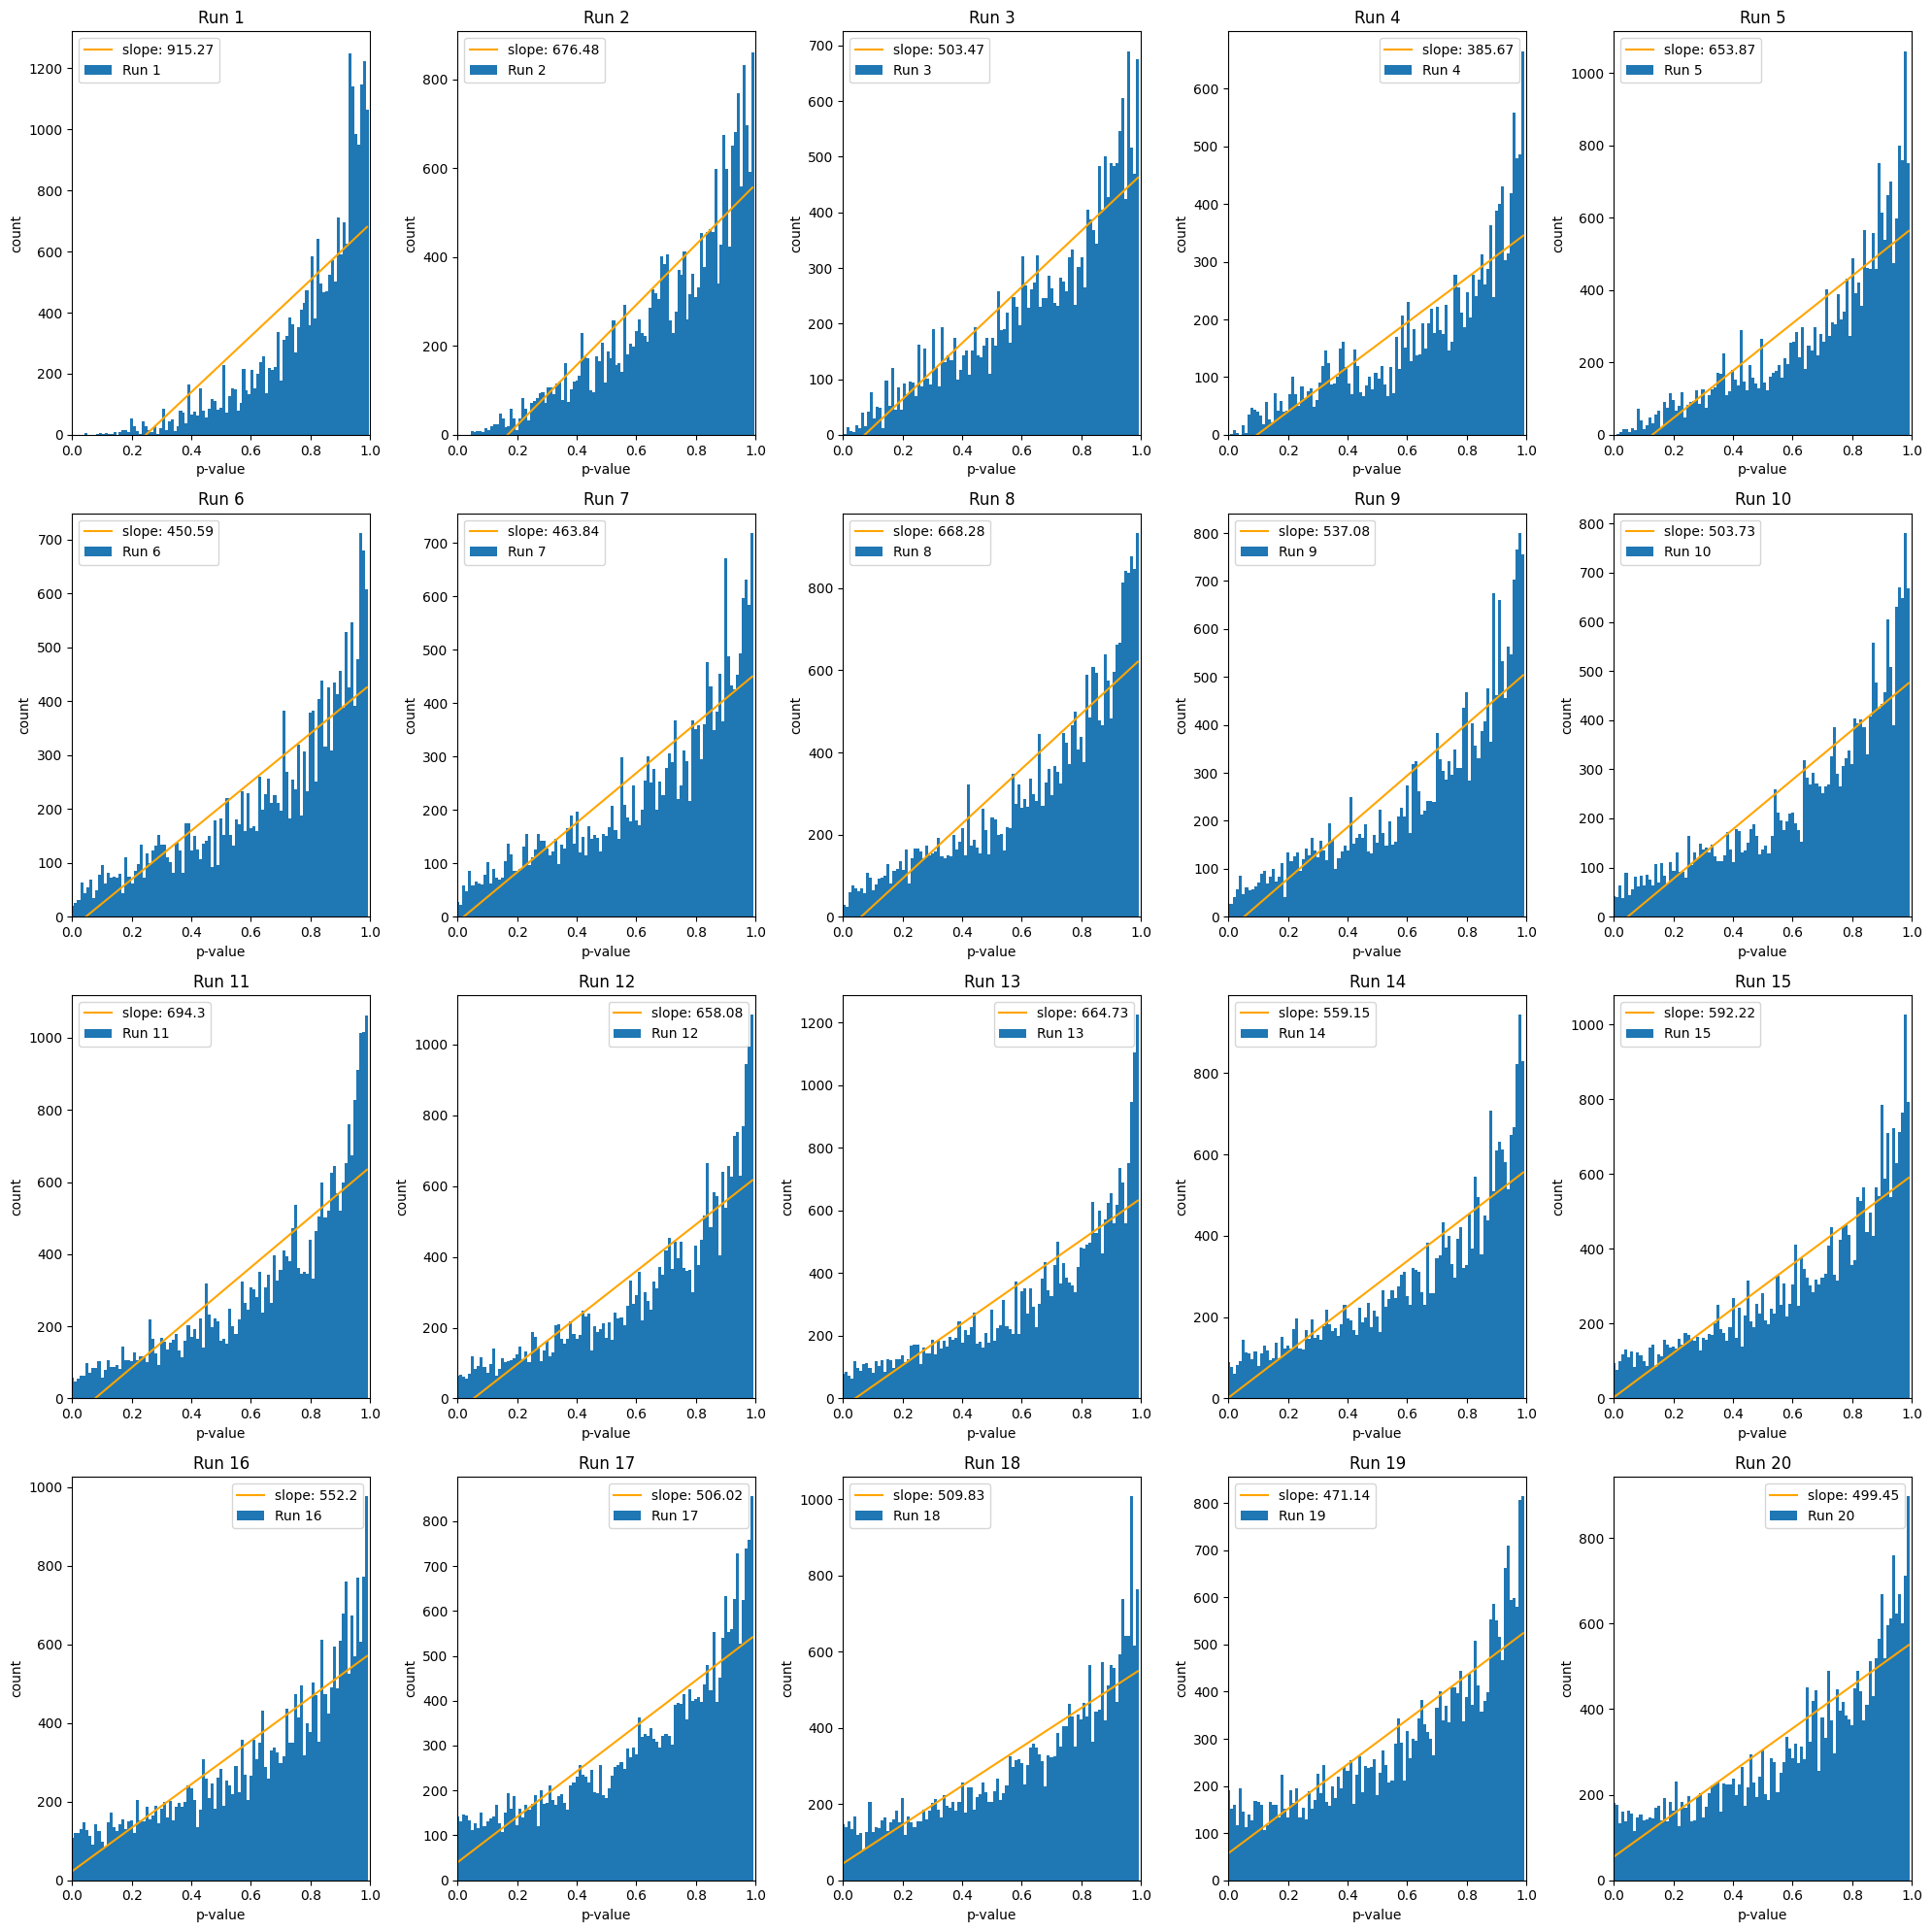

In [10]:
#plot the slopes on the histograms
#first make a function to plot the best fit line
def plot_best_fit(run, ax):
    hist, bins = np.histogram(res_dict[run]['padj'], bins=100)
    bins = bins[:-1]
    # ax.plot(bins, hist, label='Run {}'.format(run))
    #plot the histogram as bars, not lines
    ax.bar(bins, hist, width=0.01, label='Run {}'.format(run))
    #make the line orange
    ax.plot(bins, slope_df.loc[run, 'slope']*bins + best_fit.loc[run, 'intercept'], label='slope: {}'.format(round(slope_df.loc[run, 'slope'], 2)), color='orange')
    ax.legend()
    ax.set_xlabel('p-value')
    ax.set_ylabel('count')
    ax.set_title('Run {}'.format(run))
    ax.set_xlim(0, 1)
    #set the y axis to only positive values
    ax.set_ylim(0, ax.get_ylim()[1])
    return ax
#plot the best fit lines
fig, axes = plt.subplots(4, 5, figsize=(20, 20))
axes = axes.flatten()
for i in range(1, 21):
    plot_best_fit(i, axes[i-1])
plt.tight_layout()
plt.savefig('pval_hist_best_fit.png', bbox_inches='tight', dpi=300)


In [11]:
sig_genes = {}
for i in range(1, 21):
    sig_genes[i] = res_dict[i][res_dict[i]['padj'] < 0.05].index.to_list()

In [12]:
#for each gene list get the number of genes that are in the other gene lists
overlap_df = pd.DataFrame(index=sig_genes.keys(), columns=sig_genes.keys())
for i in range(1,21):
    for j in range(1,21):
        overlap_df.loc[i, j] = len(set(sig_genes[i]).intersection(set(sig_genes[j])))


In [13]:
overlap_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
2,1,8,8,5,7,7,6,6,6,6,6,6,7,7,7,7,7,7,7,7
3,1,8,33,13,28,31,31,31,31,31,31,31,32,31,31,32,32,32,32,32
4,0,5,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
5,0,7,28,13,39,37,37,38,38,37,38,38,38,38,38,38,38,38,38,38
6,0,7,31,13,37,180,179,163,155,153,156,162,165,161,172,173,175,173,173,173
7,0,6,31,13,37,179,238,201,197,187,187,198,215,209,225,226,229,229,230,225
8,0,6,31,13,38,163,201,244,216,200,210,218,226,221,231,235,238,236,238,235
9,0,6,31,13,38,155,197,216,236,205,197,207,219,217,227,231,231,230,230,225
10,0,6,31,13,37,153,187,200,205,238,218,225,232,229,235,236,236,235,234,232


In [14]:
overlap_df_frac = overlap_df / overlap_df.max(axis=0)

In [15]:
overlap_df = overlap_df.astype(int)

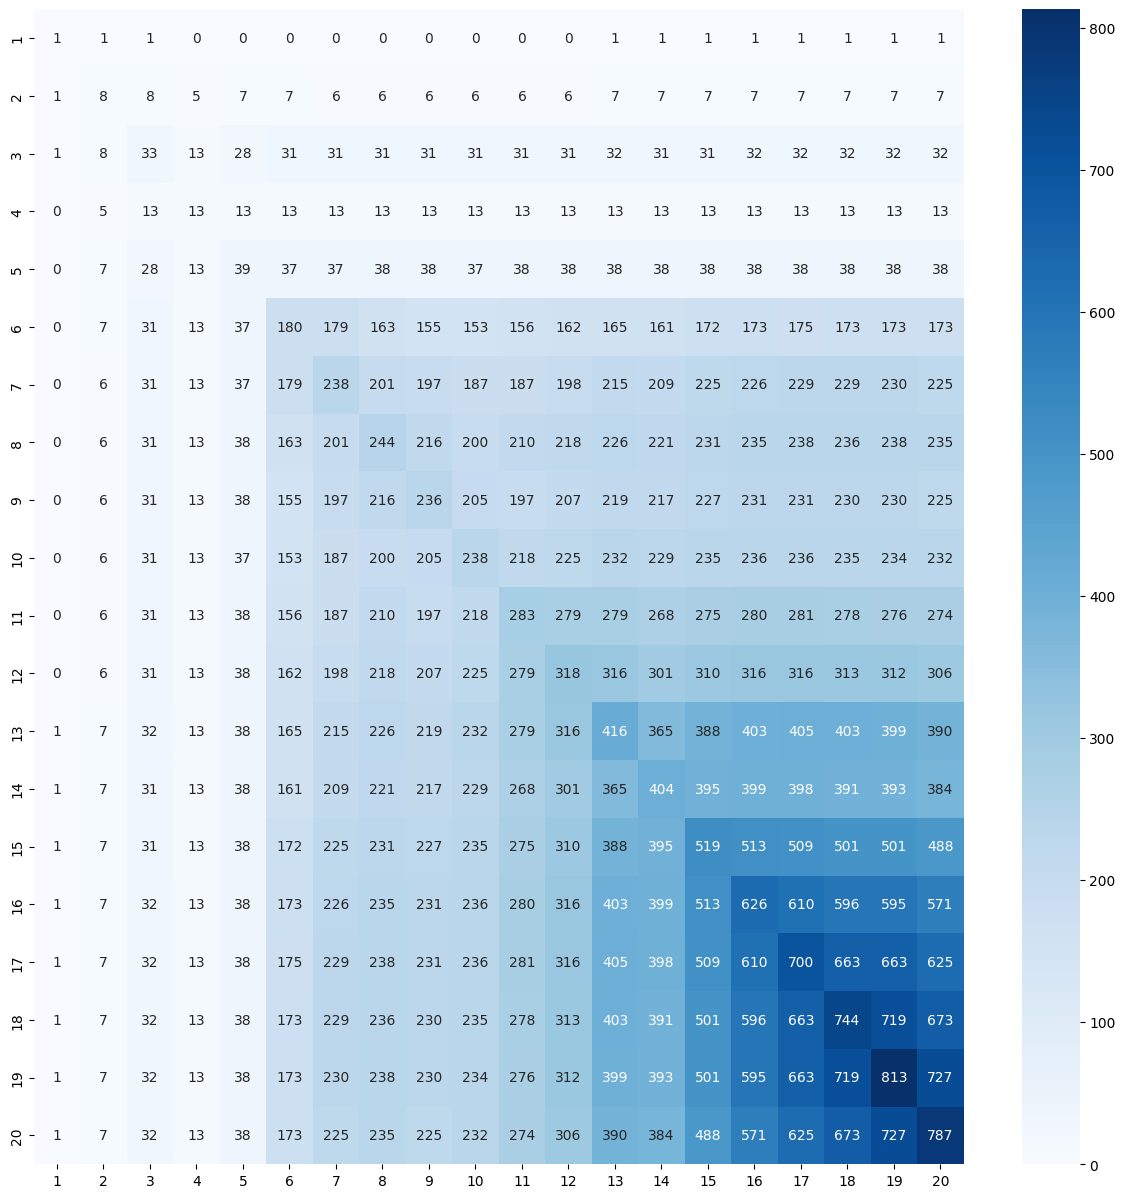

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(overlap_df, annot=True, cmap='Blues', fmt='d')
#make the plot bigger
plt.rcParams['figure.figsize'] = [15, 15]
plt.savefig('overlap_heatmap.png', bbox_inches='tight', dpi=300)

In [18]:
#create a dataframe of the top 20 genes for each run
top_20_df = pd.DataFrame(index=range(1, 21), columns=range(1, 21))
for i in range(1, 21):
    top_20_df.loc[i] = res_dict[i]['symbol'][:20].to_list()
top_20_df = top_20_df.T
top_20_df.head(15)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,APOA1,APOA1,FERMT3,FERMT3,FERMT3,FERMT3,FERMT3,FERMT3,FERMT3,FERMT3,ENSG00000283537,WASH4P,ENSG00000283537,ENSG00000283537,ENSG00000283537,ENSG00000283537,FERMT3,FERMT3,FERMT3,FERMT3
2,RNF144B,SUCLA2,APOA1,SIRPB1,ENSG00000236723,ENSG00000279281,KCNAB1,ATP5MK,ENSG00000279281,ENSG00000279281,WASH4P,ENSG00000283537,WASH4P,ASPHD2,FERMT3,SLAMF7,ENSG00000283537,ENSG00000283537,ENSG00000283537,LAX1
3,FERMT3,RNF144B,RHBDF2,SHKBP1,ENSG00000279281,KCNAB1,ENSG00000279281,KCNAB1,ATP5MK,ATP5MK,ATP5MK,ENSG00000279281,FERMT3,FERMT3,FLI1,FERMT3,SLAMF7,SLAMF7,SLAMF7,ENSG00000283537
4,FAM167A,FERMT3,SUCLA2,ENSG00000279281,SIRPB1,ITGA1,ATP5MK,ENSG00000279281,KCNAB1,IGKJ1,RAB30,ATP5MK,IGKJ1,ATP5MK,ASPHD2,FLI1,HEXD,FLI1,LAX1,SLAMF7
5,SHKBP1,FAM167A,RNF166,SUCLA2,RHBDF2,ENSG00000236723,ITGA1,ITGA1,ITGA1,FLI1,FERMT3,CST7,ENSG00000279281,IGKJ1,ATP5MK,SLC2A3,LAX1,HEXD,SUCLA2,SUCLA2
6,MUC16,SHKBP1,SHKBP1,RNF144B,SUCLA2,RNF166,ENSG00000236723,ENSG00000236723,ENSG00000236723,EME2,ENSG00000279281,RAB30,ATP5MK,ENSG00000279281,IGKJ1,CST7,KCNAB1,LAX1,HAPLN4,CDH19
7,SIRPB1,MUC16,KCNAB1,RNF166,RNF144B,SHKBP1,EME2,EME2,EME2,ITGA1,KCNAB1,FERMT3,ASPHD2,SUCLA2,HCAR3,FBXO30,FLI1,KCNAB1,CST7,CST7
8,GPR68,EME2,EME2,RHBDF2,RNF166,CHST11,SUCLA2,RNF166,RNF166,KCNAB1,IGKJ1,S100A8,IGKV1-6,KCNAB1,CST7,CD244,ATP5MK,CST7,CDH19,S100A8
9,EME2,SIRPB1,ENSG00000236723,EME2,SHKBP1,ATP5MK,RNF166,SIRPB1,FLI1,ENSG00000236723,ASPHD2,KCNAB1,FHOD3,CST7,FBXO30,ASPHD2,CHST11,RNF166,FLI1,HEXD
10,FCGR3A,LIMK1,POM121L7P,ADAMTSL3,POM121L7P,POM121L7P,SIRPB1,SUCLA2,SIRPB1,GPR68,FLI1,IGKJ1,KCNAB1,CDH19,ENSG00000279281,GALNT2,IGKJ1,HCAR3,HEXD,PTK2B


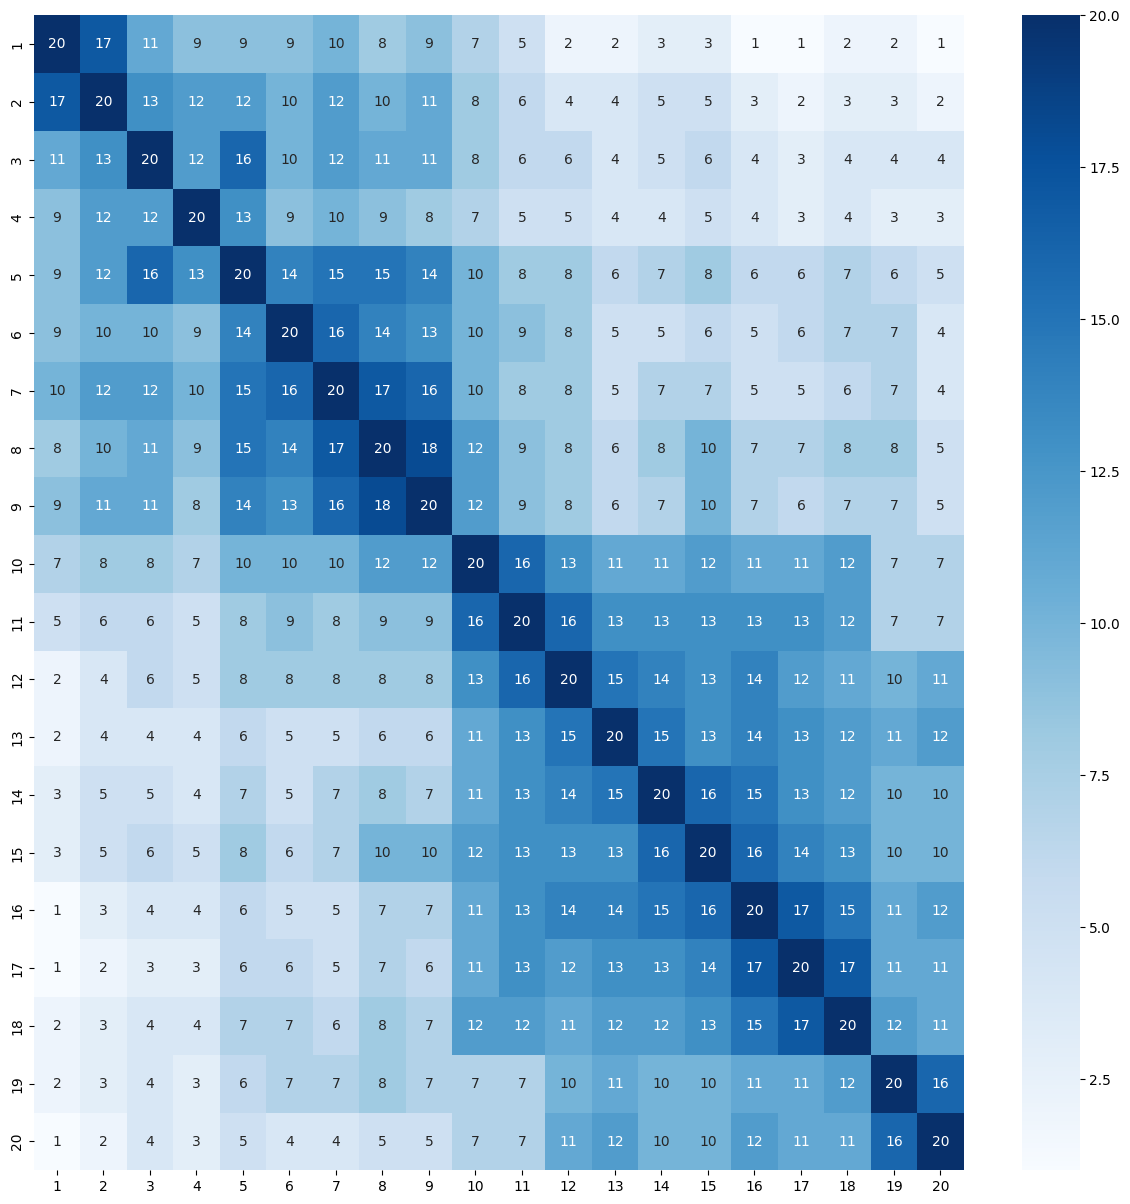

In [19]:
#make a heatmap of the top 20 genes for each run
overlap_20_df = pd.DataFrame(index=top_20_df.columns, columns=top_20_df.columns)
for i in range(1,21):
    for j in range(1,21):
        overlap_20_df.loc[i, j] = len(set(top_20_df[i]).intersection(set(top_20_df[j])))
overlap_20_df = overlap_20_df.astype(int)
sns.heatmap(overlap_20_df, annot=True, cmap='Blues', fmt='d')
#make the plot bigger
plt.rcParams['figure.figsize'] = [15, 15]
plt.savefig('top_20_heatmap.png', bbox_inches='tight', dpi=300)

In [20]:
#save run 19 to csv
res_19 = res_dict[19]
res_19.set_index('symbol', inplace=True, drop=False)
res_19.to_csv('res5_19_symbol.csv')